In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import sys, os
import subprocess
import bs4

In [2]:
import aux_functions
import crawler_v0
import strategies.momentum_v1
from aux_functions import *
from strategies.momentum_v1 import momentumStrategy

In [3]:
# Load the list of ETF
etfList   = pd.read_csv('./00_data/0_marketList/etf_list.csv',encoding='euc-kr',dtype='str')
ETFgears  = etfList.loc[:,'추적배수'].values # gearing rates of ETFs
ETFassets = etfList.loc[:,'기초자산분류'].values # underlying assets of ETFs
ETFmarkets= etfList.loc[:,'기초시장분류'].values # the market where ETFs are belonged
# Select the stock-based domestic ETFs with gear rate 1
bKrStockETF = np.logical_and(\
                            np.logical_and(ETFgears == '일반 (1)'\
                                           ,ETFassets == '주식')\
                             ,ETFmarkets == '국내')
KrStockETF=etfList[bKrStockETF]
KrStockETFcode = KrStockETF.loc[:,'단축코드'].values
# Select the bond-based domestic ETFs with gear rate 1
bKrBondETF = np.logical_and(\
                            np.logical_and(ETFgears == '일반 (1)'\
                                           ,ETFassets == '채권')\
                            ,ETFmarkets == '국내')
KrBondETF=etfList[bKrBondETF]
KrBondETFcode = KrBondETF.loc[:,'단축코드'].values

In [4]:
test2 = momentumStrategy()
test2.initialisePortfolio(initDate=datetime.date(1900,1,1)\
                            ,rebalPeriod=datetime.timedelta(days=3)\
                            ,rebalScope =datetime.timedelta(days=7)\
                            ,initVal=100000000\
                            ,assetCodes=[KrBondETFcode[2],KrStockETFcode[3],KrStockETFcode[4]\
                                        ,KrStockETFcode[5],KrStockETFcode[6],KrStockETFcode[7]]\
                            ,assetWeights=[0.6,0.2,0.1\
                                        ,0.05,0.03,0.02]\
                            ,storageDir='./00_data/1_pricesData/0_ETF'\
                            ,allowFrac=False)
test2.verbInitialCond()

[momentumStrategy:initialisePortfolio]Initial point is even prior to the head of the data. Replace it with  2018-02-27
Initial condition of the portfolio
----------------------------------------
Storage path :  ./00_data/1_pricesData/0_ETF
asset codes  :  ['114100', '287300', '287310', '290080', '284980', '287320']
asset weights:  [0.6, 0.2, 0.1, 0.05, 0.03, 0.02]
Initial value:  100000000
Initial date :  2018-02-27
Rebal. period:  3  days
Rebal. scope :  7  days
allos fract. :  False
veto (-)asset:  True


In [5]:
test2History = test2.getHistory()

[momentumStrategy:doRebalance] 2018-03-05, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2018-03-06, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2018-03-07, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2018-03-08, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2018-09-19, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2018-10-15, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2019-03-05, all assets show returns less than 1 in the scope. Rebalancing will be tried next day again.
[momentumStrategy:doRebalance] 2019-03-11, all assets s

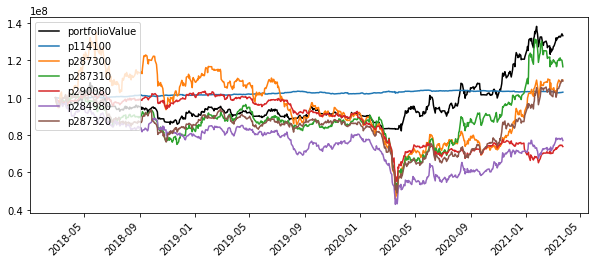

In [6]:
%matplotlib inline
test2_fig, test2_ax = drawHistory(test2History)

In [16]:
import fractions
from fractions import Fraction

def analysePortfolio(data:pd.DataFrame):
    _nAssets = int((len(data.columns)-4)/3)
    _assets  = np.array([ asset.strip('p') for asset in data.columns.values[-2-_nAssets:-2] ])
    _portfolioValues = data['portfolioValue'].values
    _assetWeights    = np.array([ Fraction(_portfolioValues[0],_nAssets*int(data.iloc[0]['p'+asset])) for asset in _assets])
    
    _benchmarkValues = np.array([sum(_assetWeights*data.loc[i,np.array(['p'+asset for asset in _assets])])
                                for i in range(len(data))])
    _portfolioReturns= np.array([_portfolioValues[i+1]/_portfolioValues[i] for i in range(len(_portfolioValues)-1) ]) 
    _benchmarkReturns= np.array([_benchmarkValues[i+1]/_benchmarkValues[i] for i in range(len(_benchmarkValues)-1) ])
    _ultimateReturns = np.array([np.max(np.array([data.iloc[i+1]['p'+asset]/data.iloc[i]['p'+asset] for asset in _assets ]))
                                 for i in range(len(data)-1) ])
#    print (np.array([_portfolioReturns,_ultimateReturns,_portfolioReturns/_ultimateReturns]).T)
#    print (np.product(_portfolioReturns)/np.product(_ultimateReturns))
    _pCumReturns = np.array([np.product(_portfolioReturns[:i+1]) for i in range(len(_portfolioReturns))])
    _bCumReturns = np.array([np.product(_benchmarkReturns[:i+1]) for i in range(len(_benchmarkReturns))])
    _uCumReturns = np.array([np.product( _ultimateReturns[:i+1]) for i in range(len( _ultimateReturns))])
    _crFig, _crAx = plt.subplots(1,1,sharex=True, figsize=(10,4))
    _crAx.plot_date(x=data['date'].values[1:], y=_pCumReturns, fmt='-k',label='portfolio')
    _crAx.plot_date(x=data['date'].values[1:], y=_bCumReturns, fmt='-b',label='benchmark')
#    _crAx.plot_date(x=data['date'].values[1:], y=_uCumReturns, fmt='--r',label='upper bound')
    _crAx.legend(loc='upper left')
#    _crAx.set_yscale('log',base=10)
    _crFig.autofmt_xdate(rotation=45)
    
    _pMDD, _pMDDfrom, _pMDDto = getMDD(data)
    
    _bDrops = np.array([ [np.min(_benchmarkValues[i:])/_benchmarkValues[i],i+np.argmin(_benchmarkValues[i:])]
                        for i in range(len(_benchmarkValues)) ])
    _bMDDfromIndx = np.argmin(_bDrops,axis=0)[0]
    [_bMDD, _bMDDtoIndx] = _bDrops[_bMDDfromIndx]
    _bMDD = 100.0*(1.0-_bMDD)
    _bMDDfrom, _bMDDto = data.iloc[int(_bMDDfromIndx)]['date'], data.iloc[int(_bMDDtoIndx)]['date']
    _covMat = np.cov(np.array([np.log(_benchmarkReturns),np.log(_portfolioReturns)]))
    _portfolioHPR = _portfolioValues[-1]/_portfolioValues[0]
    _benchmarkHPR = _benchmarkValues[-1]/_benchmarkValues[0]
#    print (_pMDD, _pMDDfrom, _pMDDto)
#    print (_bMDD, _bMDDfrom, _bMDDto)
#    print (_covMat)
    #return np.power(np.product(_portfolioReturns),1.0/float(len(_portfolioReturns))), _portfolioHPR, np.product(_benchmarkReturns), _benchmarkHPR
    return np.power(np.product(_portfolioReturns),1.0/float(len(_portfolioReturns))), _portfolioHPR\
            , np.power(np.product(_benchmarkReturns),1.0/float(len(_benchmarkReturns))), _benchmarkHPR\
            , _covMat, _pMDD, _bMDD, _crFig, _crAx
    

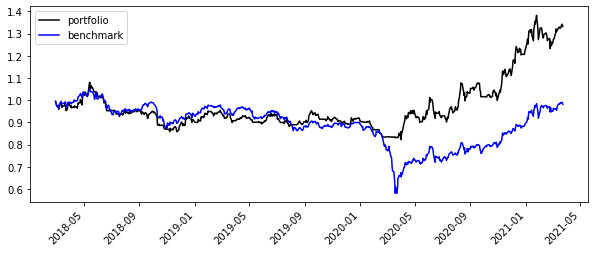

In [17]:
pMean, pHPR, bMean, bHPR, covMat, pMDD, bMDD, fig, ax = analysePortfolio(test2History)

In [11]:
pMean

1.0003807593272156

In [37]:
tempA = np.array([1,2,3,4,5,6,7])
tempB = tempA*2
tempA/tempB

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])